# Generate ground truth for Bayesian inversion problem

In [3]:
import sys
import os
import time
import numpy as np
import dolfin as dl

from scipy.interpolate import griddata

src_path = "../../../src/"
sys.path.append(src_path + 'plotting')
from field_plot import *
from plot_mix_collection import *
from point_plot import *

sys.path.append(src_path + 'pde')
from fenicsUtilities import function_to_vertex

sys.path.append(src_path + 'prior')
from priorSampler import PriorSampler

model_path = "../../problems/poisson/"
sys.path.append(model_path)
from poissonModel import PoissonModel

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# set seed
seed = 0
np.random.seed(seed)

In [4]:
data_folder = 'Results/ground_truth/'
current_directory = os.getcwd()  
results_dir = current_directory + '/' + data_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Create a deterministic diffusivity field and add some small noise to generate ground truth

In [5]:
prior_ac = 0.005
prior_cc = 0.2
prior_logn_scale = 1
prior_logn_translate = 0.
nx, ny = 50, 50
fe_order = 1
data_prefix = 'Poisson'

# create mesh
mesh = dl.UnitSquareMesh(nx, ny)

# create function spaces
Vm = dl.FunctionSpace(mesh, 'Lagrange', fe_order)
Vu = Vm

# create prior sampler
prior_sampler = PriorSampler(Vm, prior_ac, prior_cc, seed)

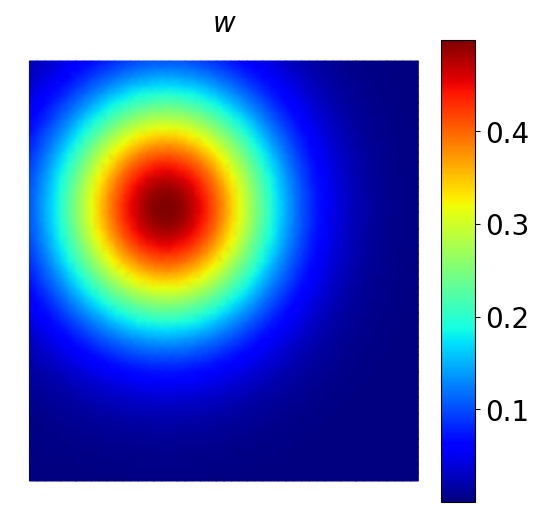

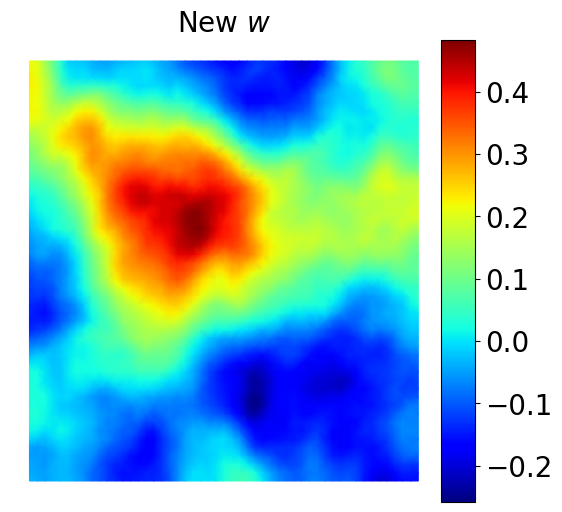

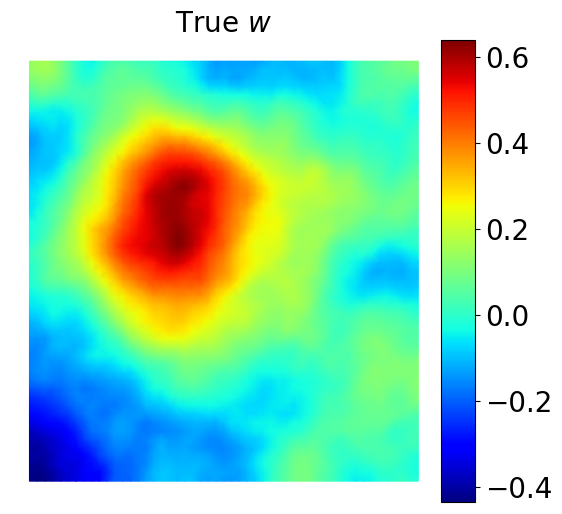

In [6]:
# create a function 
def w_field(x):
    xc, yc, r = 0.35, 0.65, 0.2
    vin, vout = 0.3, -0.3
    a, b = vin, np.log(vin - vout)
    tol = 1.e-12

    # check relative position of point x
    xx, yy = x[0] - xc, x[1] - yc
    f = (r*r - xx*xx - yy*yy)/(r*r)
    
    # set values
    if f < 1.+tol:
        # return -0.2*(2*check + 1)
        return a*np.exp(-b*f)
    else:
        return vout
    
w_fn = dl.Function(Vm)
w = function_to_vertex(w_fn, None, prior_sampler.V)
w[:] = np.array([w_field(x) for x in mesh.coordinates()])

quick_field_plot(w, mesh.coordinates(), title=r'$w$')

w = w + 0.5*prior_sampler()[0]

quick_field_plot(w, mesh.coordinates(), title=r'New $w$')

save_w = False
if save_w:
    np.save(results_dir + 'w_true.npy', w)
    quick_field_plot(w, mesh.coordinates(), title=r'True $w$')
else:
    w = np.load(results_dir + 'w_true.npy')
    quick_field_plot(w, mesh.coordinates(), title=r'True $w$')

# Create Poisson Model and generate ground truth

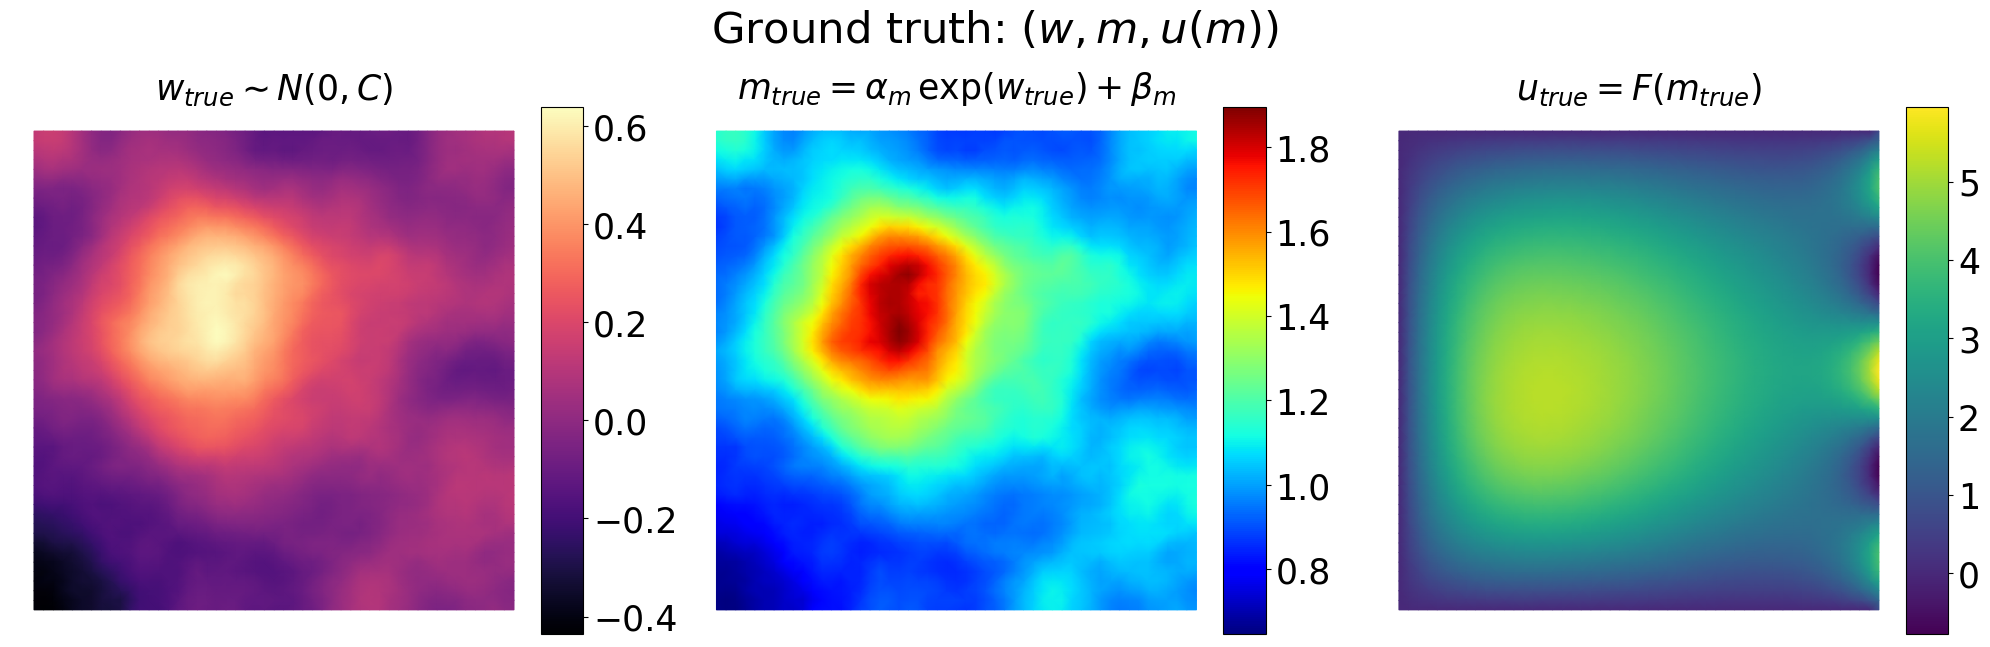

In [7]:
# create model
model = PoissonModel(Vm, Vu, prior_sampler, prior_logn_scale, prior_logn_translate, seed)

# load mean sample for Bayesian inversion
w_true = np.load(results_dir + 'w_true.npy')
m_true = model.transform_gaussian_pointwise(w_true)

# solve for u at true m
u_true = model.solveFwd(u = None, m = m_true, transform_m = False)

# plot the loaded m and true u
uvec = [[w_true, m_true, u_true]]
title_vec = [[r'$w_{true} \sim N(0, C)$', r'$m_{true} = \alpha_m\, \exp(w_{true}) + \beta_m$', r'$u_{true} = F(m_{true})$']]
cmap_vec = [['magma', 'jet', 'viridis']]
plot_collection(uvec, 1, 3, model.m_nodes, \
                    title_vec = title_vec, sup_title = r'Ground truth: $(w, m, u(m))$', \
                    cmapvec = cmap_vec, fs = 25, \
                    figsize = (20, 6), \
                    y_sup_title = 1.075, \
                    savefilename = results_dir + 'true_w_m_u.png')

# State to observable - interpolate temperature at grid points which will serve as observable

x_obs.shape = (256, 2)
grid_w.shape = (16, 16), grid_m.shape = (16, 16), grid_u.shape = (16, 16)
****************************************
****************************************
Data is not saved!
****************************************
****************************************


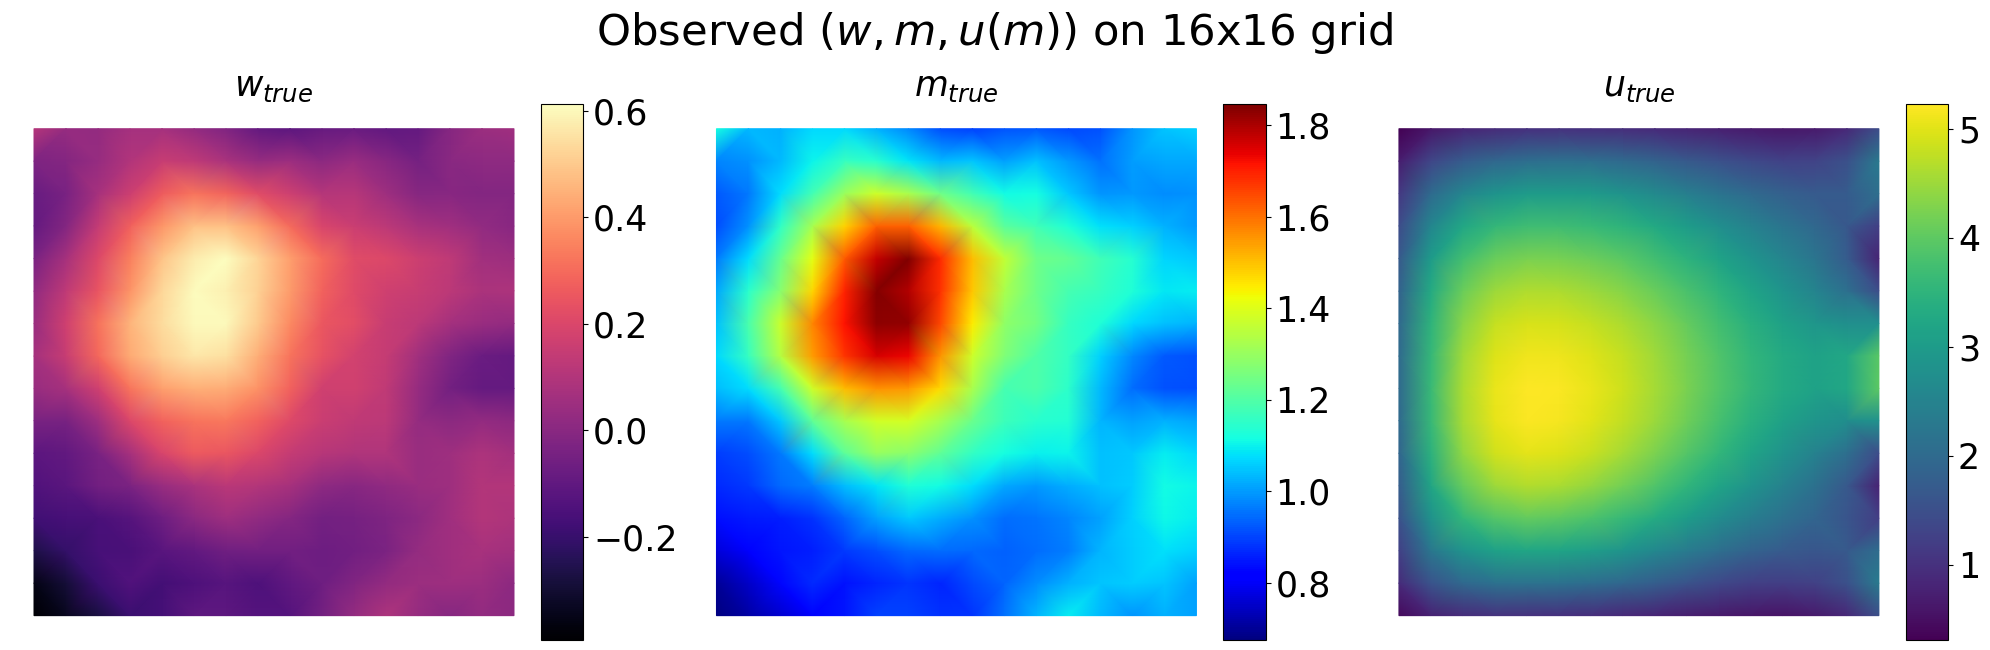

In [7]:
# get set of points on area of interest
num_grid_x, num_grid_y = 16, 16
grid_x, grid_y = np.meshgrid(np.linspace(0.05, 0.95, num_grid_x), np.linspace(0.05, 0.95, num_grid_y), indexing='ij')
x_obs = np.vstack([grid_x.flatten(), grid_y.flatten()]).T

print('x_obs.shape = {}'.format(x_obs.shape))

# interpolate u at grid points
# grid_w = griddata(model.m_nodes, w_true, (grid_x, grid_y), method='linear')
grid_w = griddata(model.m_nodes, w_true, (x_obs[:,0].reshape(num_grid_x, num_grid_y), x_obs[:,1].reshape(num_grid_x, num_grid_y)), method='linear')
grid_m = griddata(model.m_nodes, m_true, (grid_x, grid_y), method='linear')
grid_u = griddata(model.u_nodes, u_true, (grid_x, grid_y), method='linear')

print('grid_w.shape = {}, grid_m.shape = {}, grid_u.shape = {}'.format(grid_w.shape, grid_m.shape, grid_u.shape))

# save ground truth
w_obs = grid_w.flatten() 
m_obs = grid_m.flatten() 
u_obs = grid_u.flatten()
save_for_bayesian_grid_data = False
if save_for_bayesian_grid_data:
    np.savez(results_dir + 'data.npz', \
            num_grid_x = num_grid_x, num_grid_y = num_grid_y, \
            grid_x = grid_x, grid_y = grid_y, \
            grid_w = grid_w, grid_m = grid_m, grid_u = grid_u, \
            w_true = w_true, m_true = m_true, u_true = u_true, \
            x_obs = x_obs, \
            w_obs = w_obs, m_obs = m_obs, u_obs = u_obs)
else:
    print('*'*40)
    print('*'*40)
    print('Data is not saved!')
    print('*'*40)
    print('*'*40)

uvec = [[grid_w, grid_m, grid_u]]
title_vec = [[r'$w_{true}$', r'$m_{true}$', r'$u_{true}$']]
cmap_vec = [['magma', 'jet', 'viridis']]
plot_collection_grid(uvec, 1, 3, grid_x, grid_y, \
                    title_vec = title_vec, sup_title = r'Observed $(w, m, u(m))$ on {}x{} grid'.format(num_grid_x, num_grid_y), \
                    cmapvec = cmap_vec, fs = 25, \
                    figsize = (20, 6), \
                    y_sup_title = 1.075, \
                    savefilename = results_dir + 'observed_w_m_u.png')

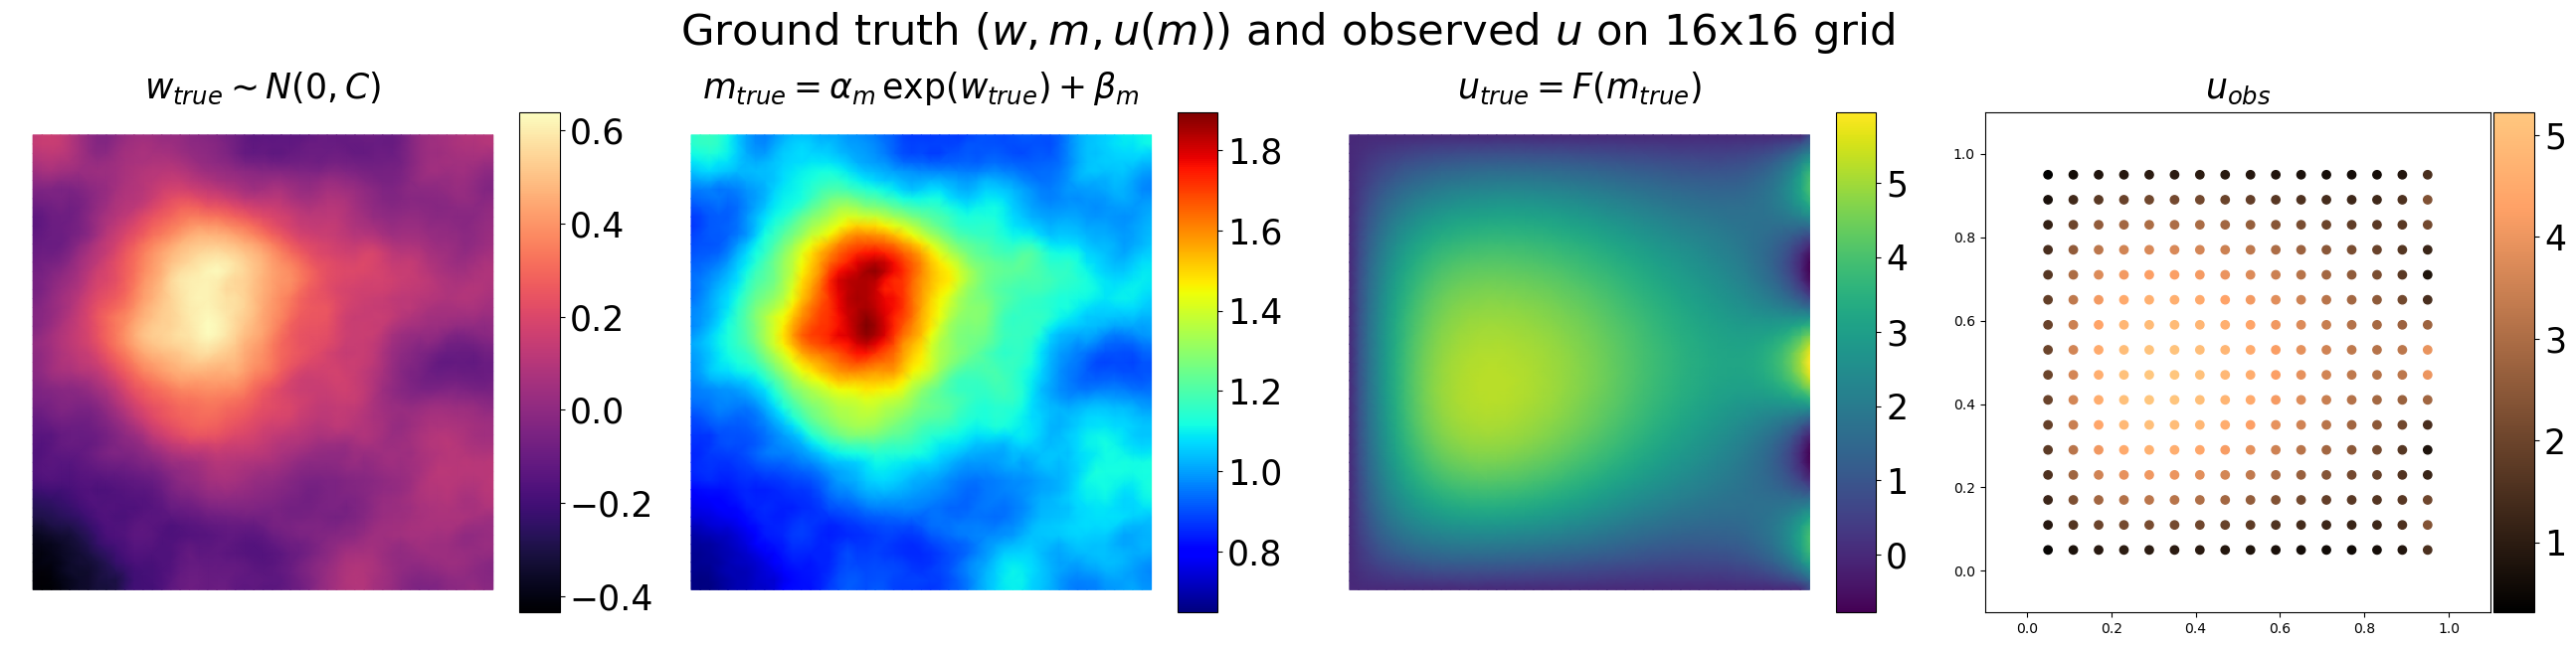

In [8]:
rows, cols = 1, 4
fig, axs = plt.subplots(rows, cols, figsize=(26, 6))
axs = np.array([axs]) if rows == 1 else axs

uvec = [[w_true, m_true, u_true]]
title_vec = [[r'$w_{true} \sim N(0, C)$', r'$m_{true} = \alpha_m\, \exp(w_{true}) + \beta_m$', r'$u_{true} = F(m_{true})$', r'$u_{obs}$']]
cmap_vec = [['magma', 'jet', 'viridis', 'copper']]
sup_title = r'Ground truth $(w, m, u(m))$ and observed $u$ on {}x{} grid'.format(num_grid_x, num_grid_y)
fs = 25
y_sup_title = 1.075
savefilename = results_dir + 'true_and_obs_w_m_u.png'

nodes = model.Vm.mesh().coordinates()


for i in range(rows):
    for j in range(cols):

        # add grid points
        if j == cols - 1:
            axs[i,j].set_xlim([-0.1, 1.1])
            axs[i,j].set_ylim([-0.1, 1.1])
        
        if j < cols - 1:
            cbar = field_plot(axs[i,j], \
                uvec[i][j], \
                nodes, cmap = cmap_vec[i][j])
        else:
            cbar = point_plot(axs[i,j], u_obs, x_obs, cmap = cmap_vec[i][j])
        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)
        cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')
        if j < cols - 1:
            axs[i,j].axis('off')
        if title_vec is not None:
            axs[i,j].set_title(title_vec[i][j], fontsize=fs, pad=10)        

fig.tight_layout()
if sup_title is not None:
    fig.suptitle(sup_title, fontsize=1.25*fs, y = y_sup_title)
if savefilename is not None:
    plt.savefig(savefilename,  bbox_inches='tight')
plt.show()

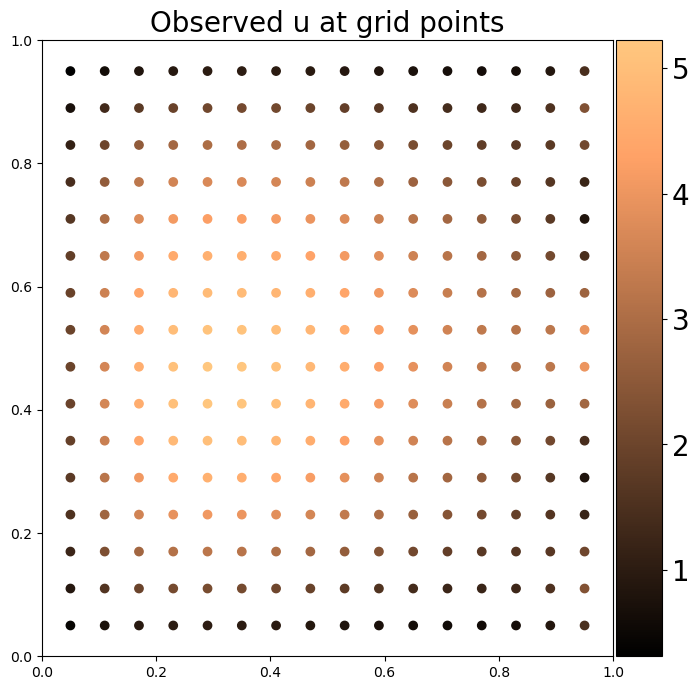

In [11]:
grid_u = griddata(model.Vu.mesh().coordinates(), u_true, x_obs, method='linear')
grid_u = grid_u.flatten()

ax_lim = np.array([[0, 0], [1, 1]])
quick_point_plot(u_obs, x_obs, title='Observed u at grid points', cmap ='copper', ax_lim = ax_lim)